Para este eda utilizaremos funciones que estan alojadas en la carpeta scripts. Alli puedes ver como funciona y su documentacion.

In [589]:
import sys
import os

# Agregar la ruta del directorio scripts
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

Empecemos un EDA de `movies_dataset` ya procesado 

In [590]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ver todas las columnas
pd.set_option('display.max_columns', None)

# Leemos todas nuestras tablas.
df = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\movies_dataset_etl.parquet')
genres_desanidado = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\genres_desanidado.parquet')
pc_desanidado = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\movies\pc_desanidado.parquet')

### Este analisis complementara el ETL pre-procesando todos los datos para usar en el modelo. Y marcando datos interesantes sobre la decision de ver una pelicula, o no. A Traves de visualizaciones.

- Son todas peliculas de duracion normal? hay series? cortos?

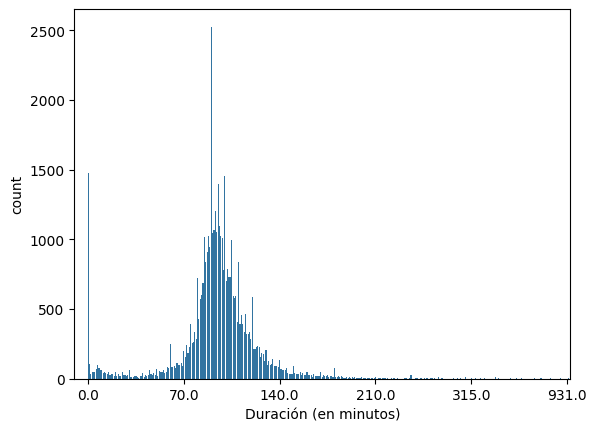

Mediana: 95.0
Media: 94.31533023089314
Moda: 90.0
desviacion std: 38.30050857440947


In [591]:
duracion = df['runtime'].dropna()
sns.countplot(x=duracion)
# Limitar el número de ejes X a 5 y correr el eje X para que 0 sea mas visible.
plt.xlim(left=-10)
plt.xticks(ticks=plt.gca().get_xticks()[::len(plt.gca().get_xticks()) // 5])
plt.xlabel('Duración (en minutos)')
plt.show()

print('Mediana:',duracion.median())
print('Media:',duracion.mean())
print('Moda:',duracion.mode()[0])
print('desviacion std:',duracion.std())

Resulta haber Miniseries, cortometrajes y peliculas.

Pero tambien nulos y muchos valores con 0 de duracion.

Vamos a rellenar los valores nulos y con 0 por su mediana(95) la cual no es afectada por outliers. Ya que la mediana es el centro de los valores ordenados.


In [592]:
mediana = int(df['runtime'].median())

# Reemplazar valores nulos (NaN) con la mediana
df['runtime'] = df['runtime'].fillna(mediana)
# Reemplazar valores de 0 con la mediana
df['runtime'] = df['runtime'].replace(0, mediana)

Ahora que no contiene nulos y su informacion esta mas distribuida. Vamos categorizar estos datos por su tiempo de duracion para verlos mejor.
Ya que su categoria puede ser mas importante que su numero de minutos. De esta forma:
- cortometraje  
- pelicula
- miniserie

In [593]:
condicion = [
    (df['runtime'] < 60), # Corto
    (df['runtime'] >= 60) & (df['runtime'] <= 200), # Pelicula
    (df['runtime'] > 200) # Mini serie
]

eleccion = ['Corto', 'Pelicula', 'Miniserie']
# Reemplazamos los datos y convertimos tipo de dato
df['runtime'] = pd.Series(np.select(condicion, eleccion, default='Desconocido'))
df['runtime'] = df['runtime'].astype(str)

Mas de 40mil datos  son peliculas.

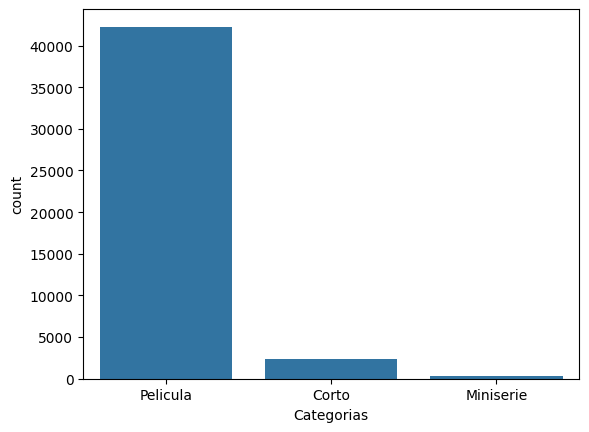

In [594]:
sns.countplot(data=df, x='runtime')
plt.xlabel('Categorias')
plt.show()

Y hay mas del cuadruple de cortometrajes que miniseries.

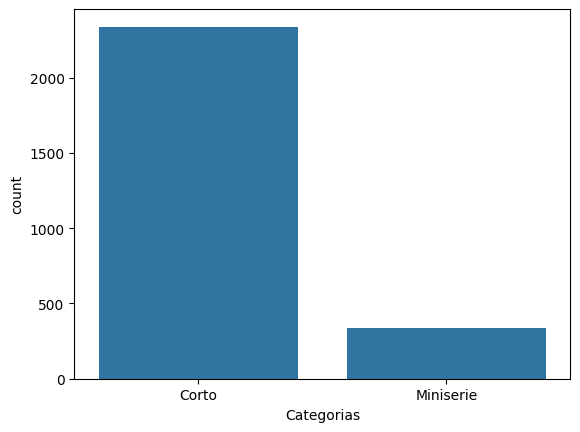

In [595]:
filtro = df[df['runtime'] != 'Pelicula']
sns.countplot(data=filtro, x='runtime')
plt.xlabel('Categorias')
plt.show()

El mes y dia en el que se estrena una pelicula es irrelevante Para el modelo. Un dato relevante podria ser su año. Veamos.. 

- eliminamos la columna de fecha completa.

In [596]:
df.drop('release_date', axis=1, inplace=True)

### La tendencia es progresiva y exponencial. Cada año salen mas peliculas que el año anterior. Y el dataset contiene casi mas peliculas en las ultimas decadas que en todos los años juntos.

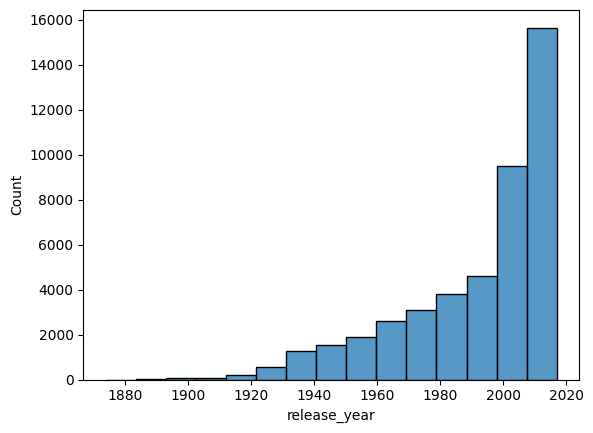

Año Pelicula mas nueva: 2017
Año Pelicula mas antigua: 1874


In [597]:
sns.histplot(df, x='release_year', bins=15)
plt.show()

print('Año Pelicula mas nueva:', df['release_year'].max())
print('Año Pelicula mas antigua:', df['release_year'].min())

Vemos que hay peliculas demasiado antiguas. Los años más antiguos tienen significativamente menos popularidad, podría ser una señal de que estos datos son menos relevantes y el punto relevante se encuentra a partir de 1900. Asi que eliminaremos esos pequeños datos menores a 1900.

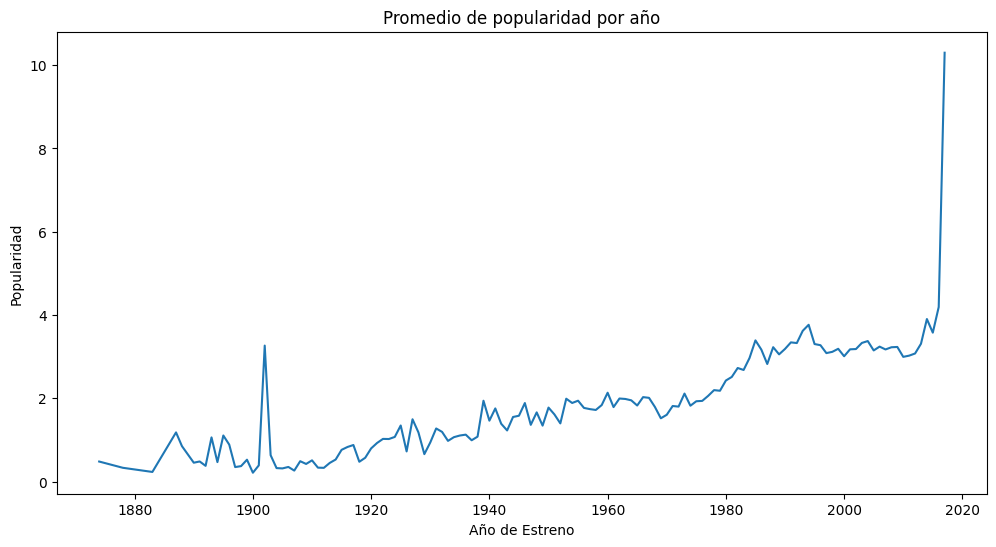

In [598]:
# Agrupa por año y calcula el promedio de votos
year_votes = df.groupby('release_year')['popularity'].mean()

# Visualiza la cantidad de votos por año
plt.figure(figsize=(12, 6))
sns.lineplot(x=year_votes.index, y=year_votes.values)
plt.xlabel('Año de Estreno')
plt.ylabel('Popularidad')
plt.title('Promedio de popularidad por año')
plt.show()

In [599]:
# Mantener los mayores a 1900
df = df[df['release_year'] > 1900]

#  Elimina las filas entre 1903 y 1935
df = df[(df['release_year'] <= 1903) | (df['release_year'] >= 1935)]

### El idioma predominante de las peliculas es:
- 1. Ingles
- 2. Frances
- 3. Italiano
- 4. Japones
- 5. Aleman

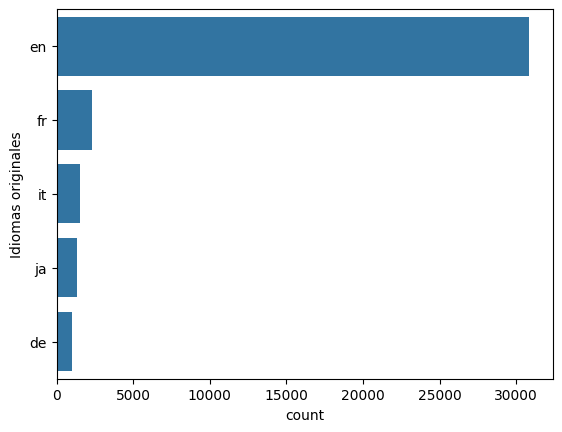

In [600]:
# Filtrar idiomas que aparecen más de 1000 veces
filtro = df.groupby('original_language').filter(lambda x: len(x) > 1000)
# Ordenar los idiomas por frecuencia de mayor a menor
orden = df['original_language'].value_counts().loc[lambda x: x > 1000].index

sns.countplot(data=filtro, y='original_language', order=orden)
plt.ylabel('Idiomas originales')

plt.show()

Optimicemos el tamaño del modelo y selectividad del usuario. Dejando solo el idioma nativo = 'es' y los 5 idiomas predominantes. 

In [601]:
idiomas = ['es', 'en', 'fr', 'it', 'ja', 'de']
df = df[df['original_language'].isin(idiomas)]

# Ahora que tenemos los idiomas. Podemos eliminar la columna spoken_language_id que se relaciona con la tabla desanidada que no nos servira.
df = df.drop('spoken_languages_id', axis=1)

Las columnas `popularity` y `vote_count` estan altamente sesgadas y su distribucion no parece ser uniforme. Apliquemos la transformacion logaritmica para verlo mejor.

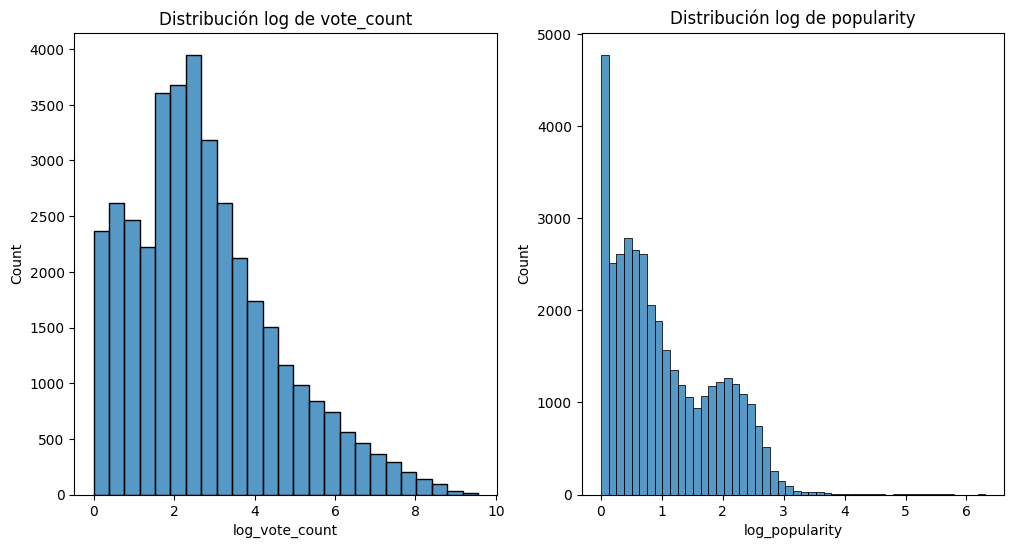

,vote_count,popularity
count,37964.000000,37964.000000
mean,127.569777,3.218450
std,534.821916,6.448026
min,0.000000,0.000000
25%,3.000000,0.430000
50%,11.000000,1.260000
75%,41.000000,4.470000
max,14075.000000,547.490000


In [602]:
# Aplicar la transformación logarítmica
df['log_vote_count'] = np.log1p(df['vote_count'])
df['log_popularity'] = np.log1p(df['popularity'])
df['log_revenue'] = np.log1p(df['revenue'])
df['log_budget'] = np.log1p(df['budget'])



fig, ax = plt.subplots(1,2,figsize=(12, 6))
# Primer gráfico: Histograma de 'vote_count'
sns.histplot(data=df, x='log_vote_count', ax=ax[0], bins=25)
ax[0].set_title('Distribución log de vote_count')

# Segundo gráfico: Histograma de 'popularity'
sns.histplot(data=df, x='log_popularity', ax=ax[1], bins=50)
ax[1].set_title('Distribución log de popularity')

plt.show()
df[['vote_count', 'popularity']].describe()

Eliminemos los quiartiles 15% que contengan muy baja popularidad y muy baja votacion. Para deshacernos de valores con 0 y ademas peliculas muy malas

In [603]:
baja_vote = df['vote_count'].quantile(0.15)  
baja_popularity = df['popularity'].quantile(0.15)  

df = df[(df['vote_count'] > baja_vote) & 
                 (df['popularity'] > baja_popularity)]

Veamos la relacion de gastos e ingresos con la popularidad y votos de una pelicula con sus datos normales y sus datos logaritmicos.

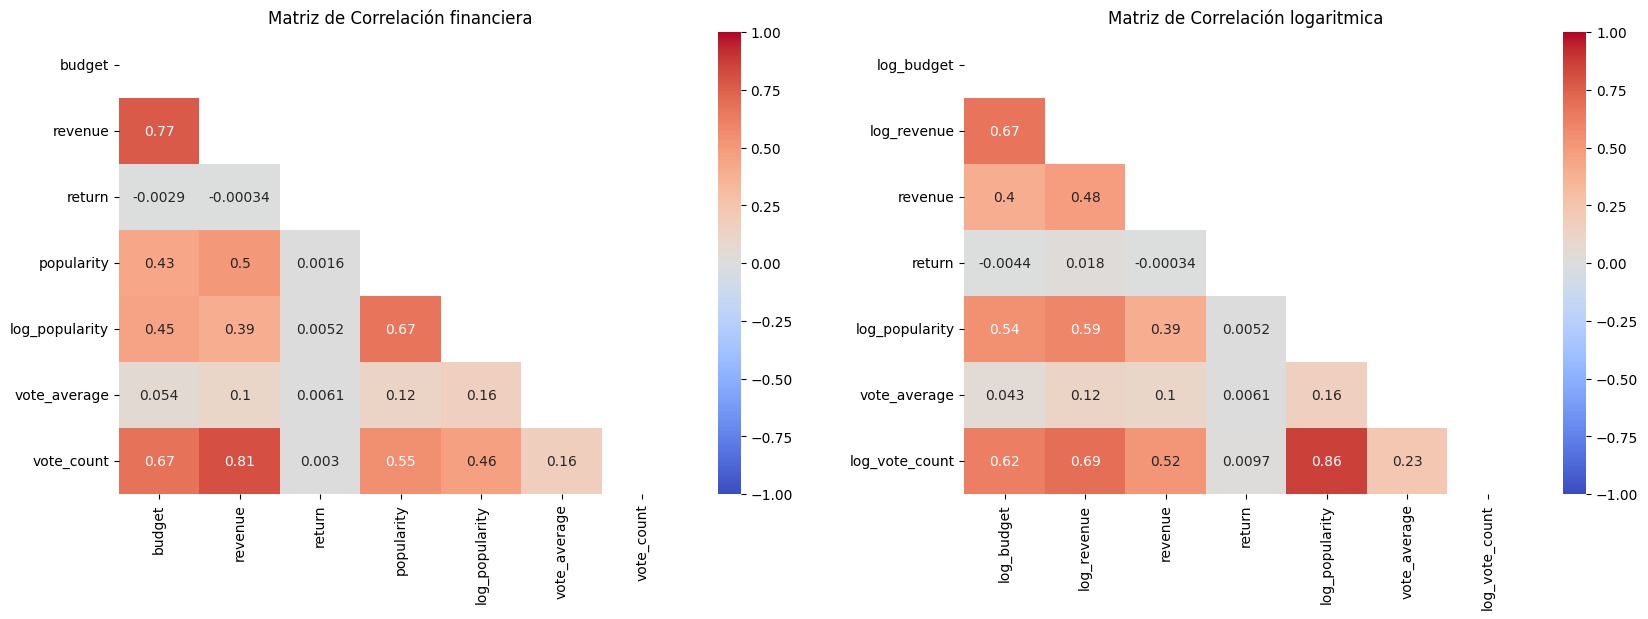

In [604]:
# Selecciona las columnas de interés
df_corr = df[['budget', 'revenue', 'return', 'popularity','log_popularity', 'vote_average', 'vote_count']]
df_corr1 = df[['log_budget', 'log_revenue','revenue', 'return', 'log_popularity', 'vote_average', 'log_vote_count']]


# Calcula la matriz de correlación
corr = df_corr.corr()
corr1 = df_corr1.corr()

fig, ax = plt.subplots(1,2,figsize=(20, 6))

# Crea un mapa de calor para visualizar la correlación
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm',mask=mask, vmin=-1, vmax=1,ax=ax[0])
ax[0].set_title('Matriz de Correlación financiera')

sns.heatmap(corr1, annot=True, cmap='coolwarm',mask=mask, vmin=-1, vmax=1,ax=ax[1])
ax[1].set_title('Matriz de Correlación logaritmica')

plt.show()

### Importante: 

La matriz de correlacion muestra que los datos normales responden mejor que los datos logaritmos.

que la popularidad y la cantidad de votos de una pelicula esta mejor dada por los ingresos sin quitar gastos. mas que por su rentabilidad luego de gastos. 

Ademas de mayor gasto = mayor ingreso. Esta informacion es importante para un productor, pero tambien para el modelo. Ya que nos quedaremos solo con la columna de `revenue` que explica mejor los datos. Y quitaremos las de `return`, `budget` y las logaritmicas. 

In [605]:
df = df.drop('return', axis=1)
df = df.drop('budget', axis=1)

df = df.drop('log_revenue', axis=1)
df = df.drop('log_budget', axis=1)
df = df.drop('log_popularity', axis=1)
df = df.drop('log_vote_count', axis=1)
df = df.drop('production_countries_id', axis=1)

Podemos eliminar btc_id ya que los id no seran importantes para el modelo. Pero el nombre de la coleccion si puede serlo. 

In [606]:
df = df.drop('btc_id', axis=1)

In [607]:
# Vemos que existen titulos de peliculas repetidos. Pero son de distintos años y popularidades. Por ende permitiremos estos duplicados.
filtro = df['title'].value_counts()
filtro

title
hamlet                        7
a christmas carol             7
jane eyre                     6
beauty and the beast          6
les misérables                6
                             ..
virtuosity                    1
while you were sleeping       1
the indian in the cupboard    1
muriel's wedding              1
waiting to exhale             1
Name: count, Length: 27578, dtype: int64

Para trabajar el modelo con las descripciones de las peliculas, verifiquemos que no existan descripciones vacias o nulas y eliminarlas en caso de haber

In [608]:
df = df.dropna(subset=['overview'])
# Cuenta las filas str que estan vacias.
vacios_count_o = df[df['overview'].str.strip() == ""].shape[0] # Contiene 2 resumenes vacios.
vacios_count_t = df[df['title'].str.strip() == ""].shape[0] # Contiene 0 titulos vacios.

df = df[df['overview'].str.strip() != ""]

Empecemos el preprocesamiento usando librerias para optimizar las descripciones

In [609]:
import nltk

# Configurar la ruta de datos de NLTK en entorno virtual
nltk.data.path.append('C:\\Users\\mauri\\OneDrive\\Escritorio\\MLops\\aaEntornoPI\\nltk_data') # Usar tu propia ruta hacia el entorno virtual.

# Descargar recursos necesarios
nltk.download('punkt_tab', download_dir='C:\\Users\\mauri\\OneDrive\\Escritorio\\MLops\\aaEntornoPI\\nltk_data')
nltk.download('stopwords', download_dir='C:\\Users\\mauri\\OneDrive\\Escritorio\\MLops\\aaEntornoPI\\nltk_data')
nltk.download('wordnet', download_dir='C:\\Users\\mauri\\OneDrive\\Escritorio\\MLops\\aaEntornoPI\\nltk_data')
nltk.download('averaged_perceptron_tagger_eng', download_dir='C:\\Users\\mauri\\OneDrive\\Escritorio\\MLops\\aaEntornoPI\\nltk_data')

[nltk_data] Downloading package punkt_tab to C:\Users\mauri\OneDrive\E
[nltk_data]     scritorio\MLops\aaEntornoPI\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\mauri\OneDrive\E
[nltk_data]     scritorio\MLops\aaEntornoPI\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\mauri\OneDrive\Esc
[nltk_data]     ritorio\MLops\aaEntornoPI\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to C:\U
[nltk_data]     sers\mauri\OneDrive\Escritorio\MLops\aaEntornoPI\nltk_
[nltk_data]     data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [610]:
from tokenizar import preprocess_text

# Aplicar la función de preprocesamiento, tokenizacion, lemmatizacion y eliminacion de nombres propios'
df['overview'] = df['overview'].apply(preprocess_text)

Vamos a enriquecer la informacion de cada futuro vector agregando al overview. La productora que la producio. con la informacion de pc_desanidado

In [611]:
pc_desanidado = pc_desanidado.drop('id', axis=1)
pc_desanidado.name = pc_desanidado['name'].fillna('')

Normalizar, quitar caracteres especiales, puntuaciones, mayusculas. Con la funcion creada y alojada en scripts

In [612]:
from normalizar import normalizar_texto

# Aplicar la normalización a la columna 'name'
pc_desanidado['name'] = pc_desanidado['name'].apply(normalizar_texto)

In [613]:
# Asegurarse que los id de pc desanidado. Esten en el df origninal. 
pc_desanidado = pc_desanidado[pc_desanidado['production_companies_id'].isin(df['production_companies_id'])]

# Ahora si podemos agrupar cada compania en una sola fila. y como se resetea el id ya estara comparado con cada id reseteado en el df orignal.
company_names = pc_desanidado.groupby('production_companies_id')['name'].apply(lambda x: ' '.join(x)).reset_index()
company_names.columns = ['production_companies_id', 'combined_companies']
company_names.shape

(28894, 2)

In [614]:
df = df.merge(company_names, on='production_companies_id', how='left')
df = df.drop('production_companies_id', axis=1)

Utilizamos la funcion para añadir peso de importancia al dato. Esta se encuentra alojada en la carpeta scripts. Y renombremos la variable a predictor. Ya que aqui pondremos todas las variables predictoras

In [615]:
from añadir_peso import add_weight
# Concatenar el contenido de 'combined_companies' al final de 'predictor', especificando su peso
df['predictor'] = df.apply(lambda row: add_weight(row, 'combined_companies', weight=1), axis=1)

Con pruebas en el modelo Notamos que agregar la compañia funciona con productoras especializadas como Pixar (infantil) Pero no para compañias de multiples tipos de peliculas. Asi que agregaremos el dato de los generos a la variable predictora.

In [616]:
genres_desanidado = genres_desanidado.drop('id', axis=1)
genres_desanidado.name = genres_desanidado['name'].fillna('')

In [617]:
from normalizar import normalizar_texto

# Aplicar la normalización a la columna 'name'
genres_desanidado['name'] = genres_desanidado['name'].apply(normalizar_texto)

In [618]:
genres_desanidado = genres_desanidado[genres_desanidado['genres_id'].isin(df['genres_id'])]

generos = genres_desanidado.groupby('genres_id')['name'].apply(lambda x: ' '.join(x)).reset_index()
generos.columns = ['genres_id', 'generos']
generos.shape

(28894, 2)

In [619]:
df = df.merge(generos, on='genres_id', how='left')
df = df.drop('genres_id', axis=1)

In [620]:
from añadir_peso import add_weight
# Concatenar el contenido al final de 'predictor', especificando su peso
df['predictor'] = df.apply(lambda row: add_weight(row, 'generos', weight=2), axis=1)

In [621]:
from añadir_peso import add_weight
# Concatenar el contenido al final de 'predictor', especificando su peso
df['predictor'] = df.apply(lambda row: add_weight(row, 'btc_name', weight=1), axis=1)

La prediccion ahora es mas precisa, pero las peliculas pueden tener descripciones muy relacionadas a peliculas demasiado antiguas, Por ejemplo una pelicula de carrera de autos esta muy relacionada a peliculas nuevas como antiguas y al compartir el genero (accion/carreras), solo su descripcion la hara resaltar. Por eso agregaremos los actores que suelen actuar en peliculas relacionadas o sagas de la pelicula para que peliculas mas modernas o continuas al titulo se relacionen.

In [622]:
cast_df = pd.read_parquet(r'C:\Users\mauri\OneDrive\Escritorio\MLops\data\processed\credits\cast_desanidado.parquet')
cast_df = cast_df.drop('id', axis=1)
cast_df = cast_df.drop('gender', axis=1)
cast_df = cast_df.drop('cast_id', axis=1)

In [623]:
cast_df.name = cast_df['name'].fillna('')

In [624]:
from normalizar import normalizar_texto

# Aplicar la normalización a la columna 'name'
cast_df['name'] = cast_df['name'].apply(normalizar_texto)

In [625]:
cast_df = cast_df[cast_df['id_df'].isin(df['id'])]
actores = cast_df.groupby('id_df')['name'].apply(lambda x: ' '.join(x)).reset_index()
actores.columns = ['id', 'actores']
actores.shape

(28280, 2)

In [626]:
df = df.merge(actores, on='id', how='left')

In [627]:
from añadir_peso import add_weight
# Concatenar el contenido al final de 'predictor', especificando su peso
df['predictor'] = df.apply(lambda row: add_weight(row, 'actores', weight=1), axis=1)

In [628]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28894 entries, 0 to 28893
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  28894 non-null  int64  
 1   original_language   28894 non-null  object 
 2   overview            28894 non-null  object 
 3   popularity          28894 non-null  float64
 4   revenue             28894 non-null  float64
 5   runtime             28894 non-null  object 
 6   title               28894 non-null  object 
 7   vote_average        28894 non-null  float64
 8   vote_count          28894 non-null  int64  
 9   release_year        28894 non-null  int64  
 10  btc_name            3620 non-null   object 
 11  combined_companies  28894 non-null  object 
 12  predictor           28894 non-null  object 
 13  generos             28894 non-null  object 
 14  actores             28295 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 3.3+

Exportamos el dataset listo para usar en el modelo. A la carpeta data/processed/ con el nombre de `modelo_dataset.parquet`

In [629]:
import sys
import os

# Verifica que el directorio de destino exista
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

In [630]:
# Ruta y nombre del archivo a guardar.
parquet_path = os.path.join(output_dir, 'modelo_dataset.parquet')
# Guarda el DataFrame en la carpeta data/processed/movies
df.to_parquet(parquet_path, engine='pyarrow', compression='snappy', index=False)

print("Datos exportados correctamente a 'data/processed/'")

Datos exportados correctamente a 'data/processed/'
